### #Calculate the moving average of order values for each customer over their order history

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

# Establish database connection
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="muhammadanees15402",
    database="ecommerce"
)

# Create a cursor object
cur = db.cursor()

In [7]:
query="""select customer_id,order_purchase_timestamp,payment,avg(payment)
over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df


,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


##2. Calculate the cumulative sales per month for each year

In [5]:
query="""select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp ) as Months,
round(sum( payments.payment_value),2)as payment
from orders join payments 
on orders.order_id = payments.order_id
group by years,Months order by years,Months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df


,0,1,2
0,2016,9,1008.96
1,2016,10,236361.92
2,2016,12,78.48
3,2017,1,553952.16
4,2017,2,1167632.04
5,2017,3,1799454.40
6,2017,4,1671152.12
7,2017,5,2371675.28
8,2017,6,2045105.52
9,2017,7,2369531.68


##3. Calculate the year-over-year growth rate of total sales.

In [7]:
query="""select year(orders.order_purchase_timestamp) as years,
round(sum( payments.payment_value),2)as payment
from orders join payments 
on orders.order_id = payments.order_id
group by years order by years"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["year","payment"])
df

,year,payment
0,2016,237449.36
1,2017,28998986.91
2,2018,34799052.21


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [4]:
query = """
WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
)
SELECT a.customer_id,
       COUNT(DISTINCT orders.order_purchase_timestamp) AS order_count
FROM a
JOIN orders ON a.customer_id = orders.customer_id
WHERE orders.order_purchase_timestamp > a.first_order
  AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
GROUP BY a.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
print(data)

[]


##5. Identify the top 3 customers who spent the most money in each year.

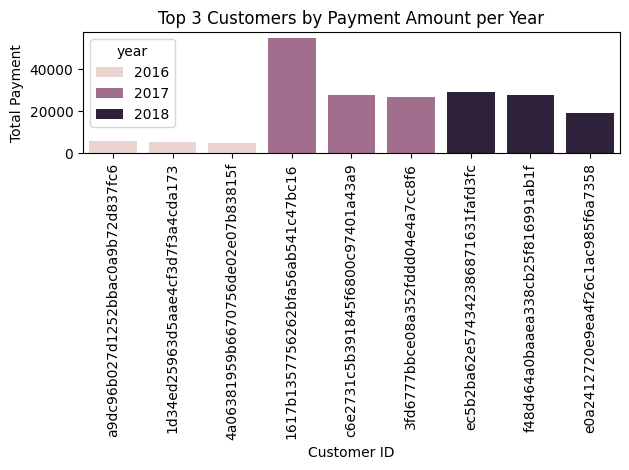

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the SQL query
query = """
select years, customer_id, payment, D_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) D_rank
from orders 
join payments on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where D_rank <= 3;
"""

# Execute the query
cur.execute(query)
data = cur.fetchall()

# Create a DataFrame
df = pd.DataFrame(data, columns=["year", "customer_id", "payment", "rank"])

# Plot the data
sns.barplot(x="customer_id", y="payment", data=df, hue="year")
plt.xticks(rotation=90)
plt.title("Top 3 Customers by Payment Amount per Year")
plt.xlabel("Customer ID")
plt.ylabel("Total Payment")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
